In [1]:
# https://github.com/pytorch/examples/blob/main/siamese_network/main.py

In [1]:
import random
import numpy as np
import sklearn

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

In [2]:
torch.cuda.is_available()

True

In [3]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = torchvision.models.resnet18(weights = None)
        
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size = (7, 7), stride = (2, 2), padding = (3, 3), bias = False)
        self.fc_in_features = self.resnet.fc.in_features
        
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace = True),
            nn.Linear(256, 1),
        )
        
        self.sigmoid = nn.Sigmoid()
        
        self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        
        output = torch.cat((output1, output2), 1)
        
        output = self.fc(output)
        
        output = self.sigmoid(output)
        
        return output

In [4]:
class APP_MATCHER(Dataset):
    def __init__(self, root, train, download = False):
        super(APP_MATCHER, self).__init__()
        
        mnist_transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,), (1.0,))
        ])
        
        self.dataset = datasets.MNIST(root, transform = mnist_transform, train = train, download = download)
        
        self.data = self.dataset.data.unsqueeze(1).clone()
        
        self.group_examples()
        
    def group_examples(self):
        np_arr = np.array(self.dataset.targets.clone())
        
        self.grouped_examples = {}
        for i in range(0, 10):
            self.grouped_examples[i] = np.where((np_arr == i))[0]
            
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        selected_class = random.randint(0, 9)
        
        random_index_1 = random.randint(0, self.grouped_examples[selected_class].shape[0] - 1)
        
        index_1 = self.grouped_examples[selected_class][random_index_1]
        
        image_1 = self.data[index_1].clone().float()
        
        # same class
        if index % 2 == 0:
            random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0] - 1)
            
            while random_index_2 == random_index_1:
                random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0] - 1)
            
            index_2 = self.grouped_examples[selected_class][random_index_2]
            
            image_2 = self.data[index_2].clone().float()
            
            target = torch.tensor(1, dtype = torch.float)
        
        # other class
        else:
            other_selected_class = random.randint(0, 9)
            
            while other_selected_class == selected_class:
                other_selected_class = random.randint(0, 9)
                
            random_index_2 = random.randint(0, self.grouped_examples[other_selected_class].shape[0] - 1)
            
            index_2 = self.grouped_examples[other_selected_class][random_index_2]
            
            image_2 = self.data[index_2].clone().float()
            
            target = torch.tensor(0, dtype = torch.float)
        
        return image_1, image_2, target

In [5]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    
    criterion = nn.BCELoss()
    
    for batch_idx, (images_1, images_2, targets) in enumerate(train_loader):
        images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images_1, images_2).squeeze() # squeeze ?
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()
            ))

In [6]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    criterion = nn.BCELoss()
    
    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:
            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)
            outputs = model(images_1, images_2).squeeze()
            test_loss += criterion(outputs, targets).sum().item()
            pred = torch.where(outputs > 0.5, 1, 0)
            correct += pred.eq(targets.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    
    print("\nTest set : Average loss : {:.4f}, Accuracy : {}/{} ({:.0f}%)\n".format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)
    ))

In [7]:
use_cuda = torch.cuda.is_available()
use_mps = torch.backends.mps.is_available()

print(use_cuda)
print(use_mps)

True
False


In [8]:
if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [9]:
batch_size = 32
test_batch_size = 32
lr = 0.001
gamma = 0.7
epochs = 10
log_interval = 1000

train_kwargs = {"batch_size" : batch_size}
test_kwargs = {"batch_size" : test_batch_size}

if use_cuda:
    cuda_kwargs = {
#         "num_workers" : 0,
                  "pin_memory" : True,
                  "shuffle" : True
    }
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

In [10]:
train_dataset = APP_MATCHER("./data", train = True, download = True)
test_dataset = APP_MATCHER("./data", train = False)
train_loader = torch.utils.data.DataLoader(train_dataset, **train_kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)

In [11]:
model = SiameseNetwork().to(device)
optimizer = optim.Adadelta(model.parameters(), lr = lr)
scheduler = StepLR(optimizer, step_size = 1, gamma = gamma)

In [12]:
image_1, image_2, label = next(iter(train_loader))
print(image_2[0].shape)
print(label[0])

torch.Size([1, 28, 28])
tensor(1.)


In [13]:
mnist_transform = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5,), (1.0,))
])

forward_once_dataset = torch.utils.data.DataLoader(
    datasets.MNIST("./data", transform = mnist_transform,train = False, download = True),
    batch_size = 16
)

images, targets = next(iter(forward_once_dataset))
print(images.shape)
print(targets.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


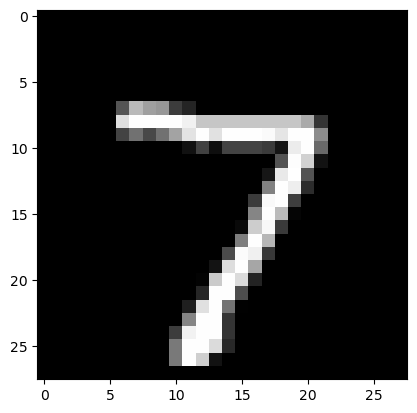

In [14]:
plt.imshow(torch.squeeze(images[0]).numpy(), cmap = 'gray')
plt.show()

In [15]:
model.eval()
print(images[0].unsqueeze(0).shape)
out = model.forward_once(images.to(device))
print(out.cpu().shape)
print(out.cpu())

torch.Size([1, 1, 28, 28])
torch.Size([16, 512])
tensor([[0.0307, 0.0000, 0.0667,  ..., 0.3817, 0.0000, 0.0000],
        [0.0507, 0.0000, 0.0225,  ..., 0.5306, 0.0146, 0.0000],
        [0.0465, 0.0000, 0.0180,  ..., 0.3555, 0.0903, 0.0000],
        ...,
        [0.0430, 0.0000, 0.0373,  ..., 0.4985, 0.0000, 0.0000],
        [0.0550, 0.0000, 0.0031,  ..., 0.5607, 0.0342, 0.0000],
        [0.0325, 0.0000, 0.1027,  ..., 0.3633, 0.0438, 0.0000]],
       grad_fn=<ToCopyBackward0>)


In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(out.cpu().detach().numpy())
df_pca = pca.transform(out.cpu().detach().numpy())
print(df_pca.shape)
print(df_pca)
print(targets.numpy())
print(targets.numpy().shape)

(16, 2)
[[ 0.3683178   0.36992124]
 [-0.34976804  0.8451909 ]
 [ 1.7242029   0.4254024 ]
 [-1.5077126   0.34012395]
 [ 0.425223   -0.60013217]
 [ 1.2671986   0.30416873]
 [-0.21392053 -0.6628214 ]
 [ 0.21546504 -0.45253596]
 [-0.46810576 -0.23584354]
 [-0.6306114  -0.7351389 ]
 [-1.1385658   0.5759301 ]
 [-0.65079373 -0.64697444]
 [ 0.01366094 -0.51530445]
 [-0.91124725  0.9378941 ]
 [ 1.4310971   0.26376754]
 [ 0.42555943 -0.21364826]]
[7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
(16,)


In [13]:
for epoch in range(1, epochs + 1):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.979976
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.773366

Test set : Average loss : 0.0229, Accuracy : 5345/10000 (53%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.739937
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.684023

Test set : Average loss : 0.0214, Accuracy : 5786/10000 (58%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.655862
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.743216

Test set : Average loss : 0.0199, Accuracy : 6264/10000 (63%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.568274
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.606107

Test set : Average loss : 0.0191, Accuracy : 6483/10000 (65%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.648004
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.550344

Test set : Average loss : 0.0183, Accuracy : 6626/10000 (66%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.681226
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.691523

Test set : Average loss : 0.0181, Accuracy : 6800/10000 (68%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.543842
T